In [1]:
def mat2df(files):
        '''
        Converts all loaded matlab variables into a single dataframe
        '''
        if not isinstance(files,list):
                files = [files]
        files = sorted(files)
        out = []
        df = pd.DataFrame()
        FNUM = 0
        for f in files:
                df2 = pd.DataFrame()
                cfold = f[0:maxstrfind(f,'/')+1]
                cf = f[maxstrfind(f,'/')+1:len(f)]
                mat = spio.loadmat(f, simplify_cells=True)
                matvars = list(mat.keys())[3:len(list(mat.keys()))]
                oldkey = list(mat.keys())[-1] #Replaces Last Key with a single hardcoded name. Assumes a single variable (ie one struct) was saved to the matfile
                for k in range(3): #pop out the first three keys. they are artifacts from the mat import
                        mat.pop(list(mat.keys())[0])
                for k in matvars:
                        if isinstance(mat[k],list):
                                for dct in mat[k]:
                                        tmp = pd.DataFrame.from_dict(dct,orient='index').T
                                        tmp['FNUM'] = FNUM
                                        df2 = pd.concat([df2,tmp])
                                mat[k] = df2
                        else:
                                mat[k] = pd.DataFrame.from_dict(mat[k]).T
                                mat[k]['FNUM'] = FNUM
                if len(matvars)>1:
                        for i in range(len(matvars)-1):
                                mat[matvars[0]] = pd.merge(mat[matvars[0]],mat[matvars[i+1]],on='FNUM')
                                # display(mat[matvars[0]])
                fdf = mat[matvars[0]].set_index('FNUM')
                fdf['Folder'] = cfold
                fdf['File'] = cf
                out.append(fdf)
                FNUM += 1
        for d in out:
                df = pd.concat([df,d])
        df = df.groupby('FNUM',as_index=False,dropna=False).ffill().groupby('FNUM',as_index=False,dropna=False).bfill() #<---Fills data gaps using adjacent rows from only the same file.
        df = df.sort_values('File')
        return df
def maxstrfind(s,p):
        '''
        Wild this doesnt exist in Python libraries. Finds LAST occurence of expression in a string.
        '''
        i = 0
        while i>-1:
                io = i
                i = s.find(p,i+1,len(s))
        return io
def datenum_to_datetime64(dnum):
        '''
        Just some Matlab DateNum nonsense
        '''
        days = np.asarray(dnum) - 719529  # shift to unix epoch (1970-01-01)
        return np.round((days * 86400000)).astype("datetime64[ms]")
def ClosestMLPreEventTF(tfdir,event_time):
        '''
        Replicates the ML ATaCR method for defining the 'nearest' TF to an event. It is a slightly different method than the Python version.
        '''
        files = g.glob(tfdir + '/*.mat')
        files = [ele for ele in files if '_AVERAGE_' not in ele] #<--Remove the station average from file list
        eventids = np.array(list(map(int,[f.split('/')[-1].split('_')[1] for f in files]))) #<Split file strings down to their event ids. Assumes format dir/stuff_EVENTID_stuff
        f = files[np.where(((np.array(event_time,dtype=int) - eventids)>0) & ((np.array(event_time,dtype=int) - eventids)==np.min((np.array(event_time,dtype=int) - eventids))))[0][0]]
        out = mat2df(f)
        return out
def organize_evdata(evdata):
        '''
        Builds ObsPy trace objects inside the dataframes from the imported Matlab data
        '''
        itr1 = (evdata['channel'].squeeze().str.find('1')>0)
        itr2 = (evdata['channel'].squeeze().str.find('2')>0)
        itrZ = (evdata['channel'].squeeze().str.find('Z')>0)
        itrP = ~((evdata['channel'].squeeze().str.find('1')>0) + (evdata['channel'].squeeze().str.find('2')>0) + (evdata['channel'].squeeze().str.find('Z')>0))
        tmp = evdata[itr1]
        tr1 = Trace(data=tmp['data'].squeeze())
        tr1.stats.sampling_rate = tmp.sampleRate.squeeze()
        tr1.stats.network = tmp.network.squeeze()
        tr1.stats.station = tmp.station.squeeze()
        tr1.stats.channel = tmp.channel.squeeze()
        tr1.stats.starttime = UTCDateTime( datenum_to_datetime64(tmp.startTime.squeeze()).tolist().strftime('%Y-%m-%dT%H:%M:%S.%f') )
        tmp = evdata[itr2]
        tr2 = Trace(data=tmp['data'].squeeze())
        tr2.stats.sampling_rate = tmp.sampleRate.squeeze()
        tr2.stats.network = tmp.network.squeeze()
        tr2.stats.station = tmp.station.squeeze()
        tr2.stats.channel = tmp.channel.squeeze()
        tr2.stats.starttime = UTCDateTime( datenum_to_datetime64(tmp.startTime.squeeze()).tolist().strftime('%Y-%m-%dT%H:%M:%S.%f') )
        tmp = evdata[itrZ]
        trZ = Trace(data=tmp['data'].squeeze())
        trZ.stats.sampling_rate = tmp.sampleRate.squeeze()
        trZ.stats.network = tmp.network.squeeze()
        trZ.stats.station = tmp.station.squeeze()
        trZ.stats.channel = tmp.channel.squeeze()
        trZ.stats.starttime = UTCDateTime( datenum_to_datetime64(tmp.startTime.squeeze()).tolist().strftime('%Y-%m-%dT%H:%M:%S.%f') )
        tmp = evdata[itrP]
        trP = Trace(data=tmp['data'].squeeze())
        trP.stats.sampling_rate = tmp.sampleRate.squeeze()
        trP.stats.network = tmp.network.squeeze()
        trP.stats.station = tmp.station.squeeze()
        trP.stats.channel = tmp.channel.squeeze()
        trP.stats.starttime = UTCDateTime( datenum_to_datetime64(tmp.startTime.squeeze()).tolist().strftime('%Y-%m-%dT%H:%M:%S.%f') )
        evdata = evdata.assign(Trace=0)
        evdata.iat[np.squeeze(np.where(itr1)).tolist(), -1] = tr1
        evdata.iat[np.squeeze(np.where(itr2)).tolist(), -1] = tr2
        evdata.iat[np.squeeze(np.where(itrZ)).tolist(), -1] = trZ
        evdata.iat[np.squeeze(np.where(itrP)).tolist(), -1] = trP
        evdata.tr1 = tr1
        evdata.tr2 = tr2
        evdata.trZ = trZ
        evdata.trP = trP
        return evdata
def GetML_EventData_and_TransferFunctions(event_time,network,sta,ml_preprocevent_folder = 'ML_PreProcEventData'):
        folder = ATaCR_ML_DataFolder[ml_preprocevent_folder]
        path = folder + '/' + event_time + '/*.mat'
        ml_files = g.glob(path)
        evdata = mat2df(ml_files)
        evdata = evdata[(evdata['network']==network)&(evdata['station']==sta)]
        evdata = organize_evdata(evdata)
        folder = ATaCR_ML_DataFolder['ML_CorrectedTraces']
        path = folder + '/' + network + '/' + sta + '/' + network + sta + '_' + str(event_time) + '_corrseis' + '.mat'
        ml_files = g.glob(path)
        corrected_evdata = mat2df(ml_files)
        corrected_evdata = corrected_evdata[(corrected_evdata['network']==network)&(corrected_evdata['station']==sta)]
        corrected_evdata = corrected_evdata.assign(Trace=0)
        for i in range(len(corrected_evdata)):
                tmp = corrected_evdata.iloc[i]
                tr = Trace(data=tmp['timeseries'].squeeze())
                tr.stats.sampling_rate = 1/tmp['dt']
                tr.stats.network = tmp['network']
                tr.stats.station = tmp['station']
                tr.stats.channel = tmp['label']
                tr.stats.starttime = evdata.trZ.stats.starttime
                corrected_evdata.iat[i, -1] = tr
        ftf = ATaCR_ML_DataFolder['ML_TransferFunctions'] + '/' + network + '/' + sta
        ml_tf = ClosestMLPreEventTF(ftf,event_time)
        return evdata,corrected_evdata,ml_tf
def ML_fig_event_corrected(PreProcEvent,CorrectedEvent,evstream=None, TF_list=None, fmin=1./150., fmax=2.,prefix = '',yes_filter=True,ylon=True,scale='linear',yhard=None):
        """
        Adapted from Python ATaCR code. Refactored for efficiency with a few more options. -CH-8/17/23

        Function to plot the corrected vertical component seismograms.

        Parameters
        ----------
        evstream : :class:`~obtsools.classes.EventStream`
                Container for the event stream data
        Tf_list : list
                List of Dictionary elements of transfer functions used
                for plotting the corrected vertical component.

        """
        keys = ['Z1','Z2-1','ZP-21','ZH','ZP-H','ZP']
        # Unpack vertical trace and filter
        preproc_itr1 = np.where((PreProcEvent['channel'].squeeze().str.find('1')>0))[0][0]
        preproc_itr2 = np.where((PreProcEvent['channel'].squeeze().str.find('2')>0))[0][0]
        preproc_itrZ = np.where((PreProcEvent['channel'].squeeze().str.find('Z')>0))[0][0]
        preproc_itrP = np.where(~((PreProcEvent['channel'].squeeze().str.find('1')>0) + (PreProcEvent['channel'].squeeze().str.find('2')>0) + (PreProcEvent['channel'].squeeze().str.find('Z')>0)))[0][0]
        trZ = PreProcEvent.iloc[preproc_itrZ]['Trace']
        trZ.filter(
                'bandpass', freqmin=fmin, freqmax=fmax, corners=2, zerophase=True)
        sr = trZ.stats.sampling_rate
        taxis = np.arange(0., trZ.stats.npts/sr, 1./sr)
        if ylon:
                yl = [-1e-4,1e-4]
        if yhard is not None:
                yl = yhard

        plt.figure(figsize=(8, 8))

        # plt.subplot(611)
        # plt.plot(taxis, trZ.data, 'lightgray', lw=0.5)
        # plt.yscale(scale)
        eventtime = CorrectedEvent.eventid.squeeze().to_list()[0]
        evtstamp = str(UTCDateTime(eventtime).year) + '.' + str(UTCDateTime(eventtime).julday) + '.' + str(UTCDateTime(eventtime).hour) + '.' + str(UTCDateTime(eventtime).minute)
        i = 611
        for key in keys:
                plt.subplot(i)
                if scale=='symlog':
                        plt.plot(taxis, np.abs(trZ.data), 'lightgray', lw=0.5)
                else:
                        plt.plot(taxis, trZ.data, 'lightgray', lw=0.5)
                plt.yscale(scale)
                if TF_list[key]:
                        Corrtrace = CorrectedEvent.iloc[np.where(~CorrectedEvent.label.squeeze().str.find(key))[0][0]]
                        tr = Trace(data=Corrtrace['Trace'].data,header=Corrtrace['Trace'].stats)
                        if yes_filter:
                                tr = tr.filter('bandpass', freqmin=fmin, freqmax=fmax, corners=2, zerophase=True)
                        if scale=='symlog':
                                plt.plot(taxis, np.abs(tr.data), 'k', lw=0.5)
                                plt.plot(taxis, np.abs(tr.data), 'k', lw=0.5)
                        else:
                                plt.plot(taxis, tr.data, 'k', lw=0.5)
                                plt.plot(taxis, tr.data, 'k', lw=0.5)
                        plt.yscale(scale)
                plt.title(prefix + Corrtrace.network + '.' + Corrtrace.station + ' ' + evtstamp + ': ' + key, fontdict={'fontsize': 8})
                if scale=='linear':
                        plt.gca().ticklabel_format(axis='y', style='sci', useOffset=True,scilimits=(-3, 3))
                plt.xlim((0., trZ.stats.npts/sr))
                if ylon:
                        plt.ylim(yl)
                if yhard is not None:
                        plt.ylim(yl)
                i+=1
        plt.xlabel('Time since earthquake (sec)')
        plt.tight_layout()

        return plt

def Py_fig_event_corrected(evstream, TF_list, fmin=1./150., fmax=2.,prefix=''):
        """
        Adapted ATaCR plot code with a few more options for versatility - CH-8/15/23

        Function to plot the corrected vertical component seismograms.

        Parameters
        ----------
        evstream : :class:`~obtsools.classes.EventStream`
                Container for the event stream data
        Tf_list : list
                List of Dictionary elements of transfer functions used
                for plotting the corrected vertical component.

        """

        # Unpack vertical trace and filter
        trZ = evstream.trZ.copy()
        trZ.filter(
                'bandpass', freqmin=fmin, freqmax=fmax, corners=2, zerophase=True)
        sr = trZ.stats.sampling_rate
        taxis = np.arange(0., trZ.stats.npts/sr, 1./sr)

        plt.figure(figsize=(8, 8))

        plt.subplot(611)
        plt.plot(
                taxis, trZ.data, 'lightgray', lw=0.5)
        if TF_list['Z1']:
                tr = Trace(
                data=evstream.correct['Z1'],
                header=trZ.stats).filter(
                'bandpass', freqmin=fmin, freqmax=fmax, corners=2, zerophase=True)
                plt.plot(taxis, tr.data, 'k', lw=0.5)
        plt.title(prefix + evstream.key + ' ' + evstream.tstamp +
                ': Z1', fontdict={'fontsize': 8})
        plt.gca().ticklabel_format(axis='y', style='sci', useOffset=True,
                                scilimits=(-3, 3))
        plt.xlim((0., trZ.stats.npts/sr))

        plt.subplot(612)
        plt.plot(
                taxis, trZ.data, 'lightgray', lw=0.5)
        if TF_list['Z2-1']:
                tr = Trace(
                data=evstream.correct['Z2-1'],
                header=trZ.stats).filter(
                'bandpass', freqmin=fmin, freqmax=fmax, corners=2, zerophase=True)
                plt.plot(taxis, tr.data, 'k', lw=0.5)
        plt.title(prefix + evstream.tstamp + ': Z2-1', fontdict={'fontsize': 8})
        plt.gca().ticklabel_format(axis='y', style='sci', useOffset=True,
                                scilimits=(-3, 3))
        plt.xlim((0., trZ.stats.npts/sr))

        plt.subplot(613)
        plt.plot(
                taxis, trZ.data, 'lightgray', lw=0.5)
        if TF_list['ZP-21']:
                tr = Trace(
                data=evstream.correct['ZP-21'],
                header=trZ.stats).filter(
                'bandpass', freqmin=fmin, freqmax=fmax, corners=2, zerophase=True)
                plt.plot(taxis, tr.data, 'k', lw=0.5)
        plt.title(prefix + evstream.tstamp + ': ZP-21', fontdict={'fontsize': 8})
        plt.gca().ticklabel_format(axis='y', style='sci', useOffset=True,
                                scilimits=(-3, 3))
        plt.xlim((0., trZ.stats.npts/sr))

        plt.subplot(614)
        plt.plot(
                taxis, trZ.data, 'lightgray', lw=0.5)
        if TF_list['ZH']:
                tr = Trace(
                data=evstream.correct['ZH'],
                header=trZ.stats).filter(
                'bandpass', freqmin=fmin, freqmax=fmax, corners=2, zerophase=True)
                plt.plot(taxis, tr.data, 'k', lw=0.5)
        plt.title(prefix + evstream.tstamp + ': ZH', fontdict={'fontsize': 8})
        plt.gca().ticklabel_format(axis='y', style='sci', useOffset=True,
                                scilimits=(-3, 3))
        plt.xlim((0., trZ.stats.npts/sr))

        plt.subplot(615)
        plt.plot(
                taxis, trZ.data, 'lightgray', lw=0.5)
        if TF_list['ZP-H']:
                tr = Trace(
                data=evstream.correct['ZP-H'],
                header=trZ.stats).filter(
                'bandpass', freqmin=fmin, freqmax=fmax, corners=2, zerophase=True)
                plt.plot(taxis, tr.data, 'k', lw=0.5)
        plt.title(prefix + evstream.tstamp + ': ZP-H', fontdict={'fontsize': 8})
        plt.gca().ticklabel_format(axis='y', style='sci', useOffset=True,
                                scilimits=(-3, 3))
        plt.xlim((0., trZ.stats.npts/sr))

        plt.subplot(616)
        plt.plot(
                taxis, trZ.data, 'lightgray', lw=0.5)
        if TF_list['ZP']:
                tr = Trace(
                data=evstream.correct['ZP'],
                header=trZ.stats).filter(
                'bandpass', freqmin=fmin, freqmax=fmax, corners=2, zerophase=True)
                plt.plot(taxis, tr.data, 'k', lw=0.5)
        plt.title(prefix + evstream.tstamp + ': ZP', fontdict={'fontsize': 8})
        plt.gca().ticklabel_format(axis='y', style='sci', useOffset=True,
                                scilimits=(-3, 3))
        plt.xlim((0., trZ.stats.npts/sr))

        plt.xlabel('Time since earthquake (sec)')
        plt.tight_layout()
        return plt
def TraceDelta(event_time,network,sta,respct=False,scale='linear'):
        '''Just writes residuals to the obspy trace objects to feed into ML_fig_event_corrected'''
        PreProcEvent,CorrectedEvent,ML_TFs = GetML_EventData_and_TransferFunctions(event_time,network,sta)
        for i in range(len(PreProcEvent)):
                tmp = PreProcEvent.iloc[i]['Trace']
                tmp.data = tmp.data*0
                # PreProcEvent.iloc[i]['Trace'] = tmp
                PreProcEvent.iat[i,-1] = tmp
        ML_CorrectedEvent = CorrectedEvent
        path = ATaCR_Py_DataFolder['Py_CorrectedTraces'] + '/' + network + '.' + sta + '/CORRECTED/' + network + '.' + sta + '.' + eventtime_jdaystr + '.day'
        py_files = g.glob(path + '*.pkl')
        f = py_files[0]
        # display(f)
        evstream = pkl.load(open(f,'rb'))
        keys = CorrectedEvent['label'].to_list()
        delta = pd.DataFrame.from_dict({'label':keys,'residual':[PreProcEvent.iloc[0]['data']*0 for i in range(len(keys))]})
        for k in keys:
                PyTr = evstream.correct[k]
                MLTr = CorrectedEvent.iloc[(CorrectedEvent['label']==k).to_list()].timeseries.to_list()[0]
                if respct:
                        res = ((PyTr - MLTr)/MLTr)
                else:
                        res = PyTr - MLTr
                i = np.where(delta['label']==k)[0][0]
                delta.at[i,'residual'] = res
                tmp = CorrectedEvent.iloc[i,-1]
                tmp.data = delta.at[i,'residual']
                CorrectedEvent.iloc[i,-1] = tmp
        prefix = '<Py-ML Residual Fraction>'
        ML_fig_event_corrected(PreProcEvent,CorrectedEvent,evstream=None, TF_list=TF_list, fmin=1./150., fmax=2.,prefix=prefix,yes_filter=False,ylon=False,scale=scale)

# MATLAB vs Python Versions of ATaCR

-----
	1. --------------Filtering disagreement during event correction--------------
		1. A lowpass filter & taper is performed on the transfer functions in b4_CorrectEvent that is not present anywhere in the Python version.


	2. --------------Averaging choice for deriving TFs--------------
		1. By default, both codes use the transfer functions made from the DAY AVERAGE preceding the event time. 
			1. That said, the pre-event time window that determines this TF selection is very slightly different in the two codes. The ML version requires both start and end times of the TF to preceed the event. The python version only requires the start time to be before the event (ie the event occurs WITHIN the TF window).


	3. --------------Choosing the pre-event TF--------------
		1. Unlike the Matlab version, there is nothing in the Python code to stop individual trace data (SAC files) to be less than an entire day of recording. Thus an edge case exist when querying times from IRIS to yield hour long traces (ie many deployments retain SAC files in hour resolution).


	4. --------------Tilt Searching for H--------------
		1. Both codes use the same tilt frequency range ([.005, .035]) when determining maximum coherence.


	5. --------------Filter differences--------------
		1. In the Python version, station spectra at every level of processing (ie quality control at lines 232 and 276 of atacr_clean_spectra and atacr_clean_spectra, respectively) has a SIGNIFICANTLY higher corner ([0.004 2.0] Hz) than the Matlab version ([0.004 0.2] Hz).


	6. --------------Hanning Taper Inconsistency--------------
		8. The hanning taper appears to be more than twice as long in the Python version compared to Matlab's. Admittedly, its possible ML's hanning might operate differently than Numpy's, hanning(2x_num_pts_to_overlap), but I would doubt it based on the documentation for them.
			1. Furthermore, the taper is not used in the same manner at all between the two codes. ML uses the hanning taper to correct event data (see b4_correct_event) while Python uses it prior to quality control for daily spectra (see QC_daily_spectra).


	7. --------------Inconsistencies in power spectra station averages--------------
		1. While they are station averages and not used for deriving the TFs (by default), their is marked inconsistencies in power and fq when comparing the two code outputs. As stated above, the bandpass for Python is significantly wider and although this alone wouldn't shift spectra, it's possible when this is combined with the hanning taper Python uses (and ML does not) it might create this marked disagreement in spectral averages for stations. 
			1. There is a much deeper dive needed to confirm and quantify the significant disagreements shown in how spectra are pre-processed and averaged differently between the two codes.
			2. That said, the final product of corrected event traces seem largely in agreement with each other to an extent I question whether I understand this spectra disagreement issue correctly or overestimate its effect on the ATaCR method.


	8. --------------In final product comparisons--------------
		1. The corrected event traces seem nearly identical in nearly all cases looked seen so far.


----------------------------------------------------------------------------------------


In [2]:
import obstools
from obstools.atacr import DayNoise, TFNoise, EventStream, StaNoise, utils
import obstools.atacr.plotting as atplot
from pathlib import Path
from obspy.core import read, Stream, Trace, AttribDict, UTCDateTime
import scipy.io as spio
import os
import glob as g
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
import pickle as pkl
from obstools.atacr import utils
from obspy import Trace
import pickle
import os, fnmatch
from obstools.atacr.plotting import fig_QC, fig_average, fig_av_cross, fig_coh_ph, fig_TF, fig_comply, fig_event_raw, fig_event_corrected


In [4]:
git remote -v

SyntaxError: invalid syntax (1081152809.py, line 1)

In [3]:
# Important Directories
CompFolder = '/Users/charlesh/Documents/Codes/ATaCR/ATaCR_Comp'

ATaCR_ML_DataFolder = dict()
ATaCR_ML_DataFolder['ML_ATaCR_Parent'] = CompFolder + '/ATaCR'
ATaCR_ML_DataFolder['ML_DataParentFolder'] = CompFolder + '/ATaCR/DATA'
ATaCR_ML_DataFolder['ML_RawDayData'] = ATaCR_ML_DataFolder['ML_DataParentFolder'] + '/datacache_day'
ATaCR_ML_DataFolder['ML_PreProcDayData'] = ATaCR_ML_DataFolder['ML_DataParentFolder'] + '/datacache_day_preproc'
ATaCR_ML_DataFolder['ML_RawEventData'] = ATaCR_ML_DataFolder['ML_DataParentFolder'] + '/datacache_event'
ATaCR_ML_DataFolder['ML_PreProcEventData'] = ATaCR_ML_DataFolder['ML_DataParentFolder'] + '/datacache_event_preproc'
ATaCR_ML_DataFolder['ML_StaSpecAvg'] = ATaCR_ML_DataFolder['ML_DataParentFolder'] + '/noisetc/AVG_STA'
ATaCR_ML_DataFolder['ML_CorrectedTraces'] = ATaCR_ML_DataFolder['ML_DataParentFolder'] + '/noisetc/CORRSEIS'
ATaCR_ML_DataFolder['ML_b1b2_StaSpectra'] = ATaCR_ML_DataFolder['ML_DataParentFolder'] + '/noisetc/SPECTRA'
ATaCR_ML_DataFolder['ML_TransferFunctions'] = ATaCR_ML_DataFolder['ML_DataParentFolder'] + '/noisetc/TRANSFUN'

ATaCR_Py_DataFolder = dict()
ATaCR_Py_DataFolder['Py_DataParentFolder'] = CompFolder + '/ATaCR_Python'
ATaCR_Py_DataFolder['Py_RawDayData'] = ATaCR_Py_DataFolder['Py_DataParentFolder'] + '/Data'
# ATaCR_Py_DataFolder['Py_PreProcDayData']
# ATaCR_Py_DataFolder['Py_RawEventData']
# ATaCR_Py_DataFolder['Py_PreProcEventData']
ATaCR_Py_DataFolder['Py_StaSpecAvg'] = ATaCR_Py_DataFolder['Py_DataParentFolder'] + '/AVG_STA'
ATaCR_Py_DataFolder['Py_CorrectedTraces'] = ATaCR_Py_DataFolder['Py_DataParentFolder'] + '/EVENTS'
ATaCR_Py_DataFolder['Py_b1b2_StaSpectra'] = ATaCR_Py_DataFolder['Py_DataParentFolder'] + '/SPECTRA'
ATaCR_Py_DataFolder['Py_TransferFunctions'] = ATaCR_Py_DataFolder['Py_DataParentFolder'] + '/TF_STA'

sps = 5
network = '7D'
stalist = ['M01A','M02A','M07A','M08A']
event_time = '201203090709'
eventtime_jdaystr = str(UTCDateTime(event_time).year) + '.' + str(UTCDateTime(event_time).julday).zfill(3) + '.' + str(UTCDateTime(event_time).hour).zfill(2) + '.' + str(UTCDateTime(event_time).minute).zfill(2)
# files = g.glob(ATaCR_ML_DataFolder['ML_RawDayData'] + '/' + network + '/' + sta + '/*.mat')
# files = g.glob(ATaCR_ML_DataFolder['ML_PreProcDayData'] + '/' + network + '/' + sta + '/*.mat')
# files = g.glob(ATaCR_ML_DataFolder['ML_RawEventData'] + '/' + event_time + '/*.mat')
# files = g.glob(ATaCR_ML_DataFolder['ML_PreProcEventData'] + '/' + event_time + '/*.mat')
# files = g.glob(ATaCR_ML_DataFolder['ML_StaSpecAvg'] + '/*.mat')
# files = g.glob(ATaCR_ML_DataFolder['ML_CorrectedTraces'] + '/' + network + '/' + sta + '/*.mat')
# files = g.glob(ATaCR_ML_DataFolder['ML_b1b2_StaSpectra'] + '/' + network + '/' + sta + '/b1/*.mat')
# files = g.glob(ATaCR_ML_DataFolder['ML_b1b2_StaSpectra'] + '/' + network + '/' + sta + '/b2/*.mat')
# files = g.glob(ATaCR_ML_DataFolder['ML_TransferFunctions'] + '/' + network + '/' + sta + '/*.mat')

'/Users/charlesh/Documents/Codes/ATaCR/ATaCR_Comp/ATaCR_Python/EVENTS/7D.M01A/CORRECTED/7D.M01A.2012.069.07.09.day.pkl'

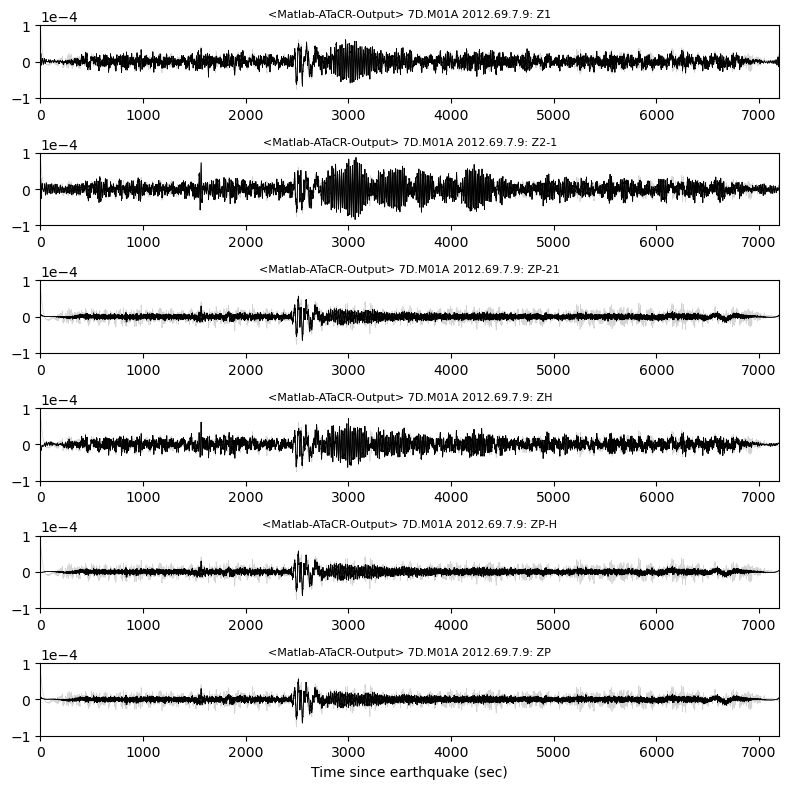

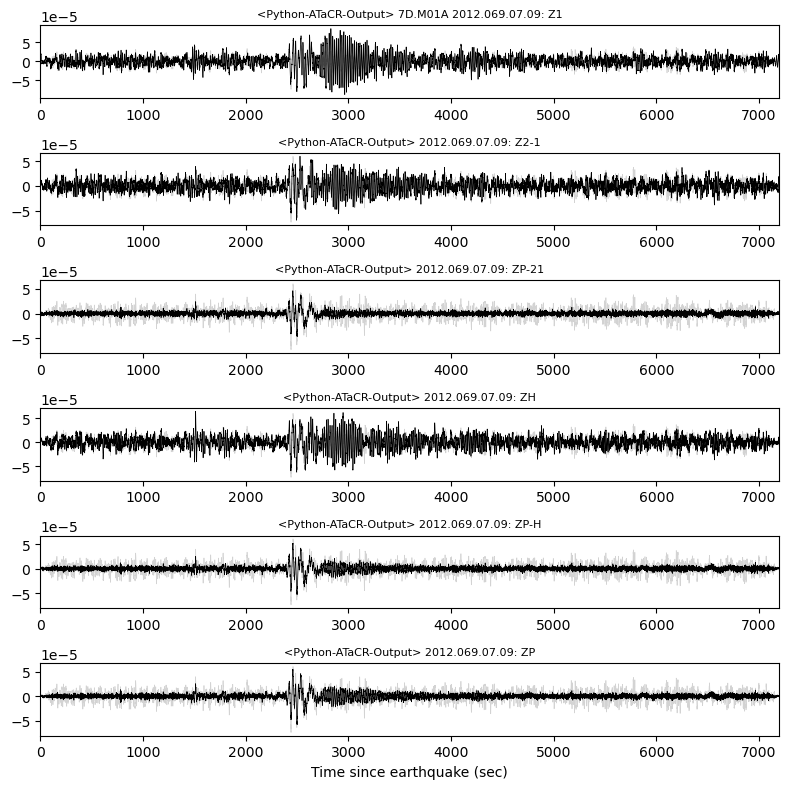

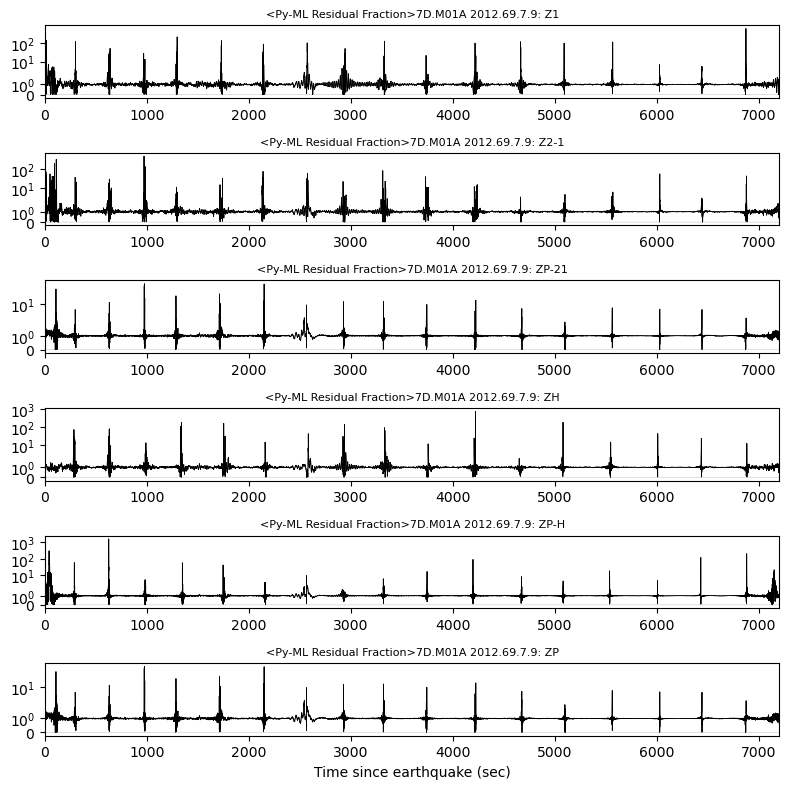

---------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------


'/Users/charlesh/Documents/Codes/ATaCR/ATaCR_Comp/ATaCR_Python/EVENTS/7D.M02A/CORRECTED/7D.M02A.2012.069.07.09.day.pkl'

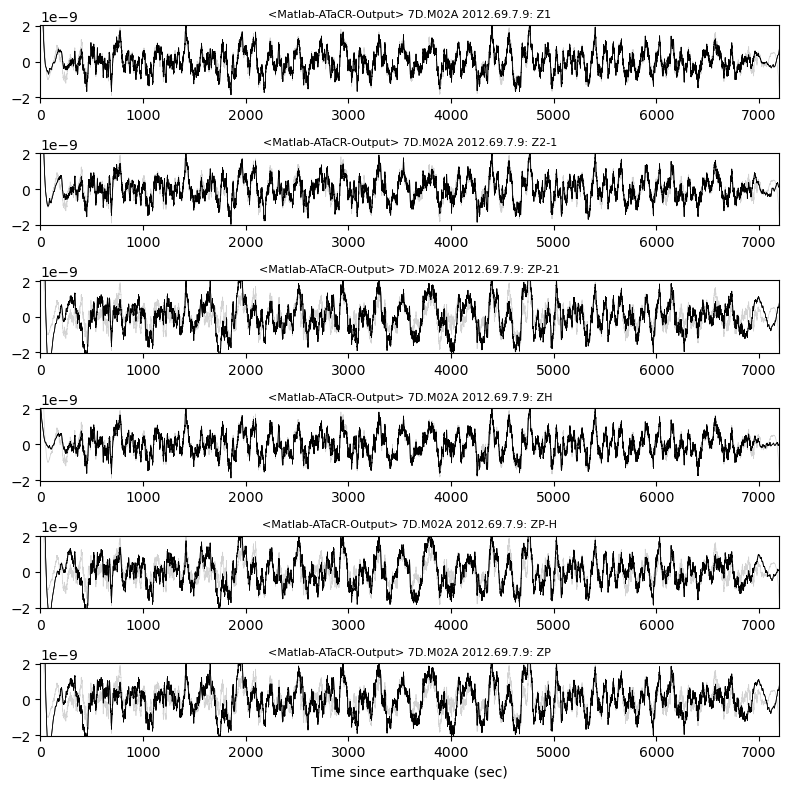

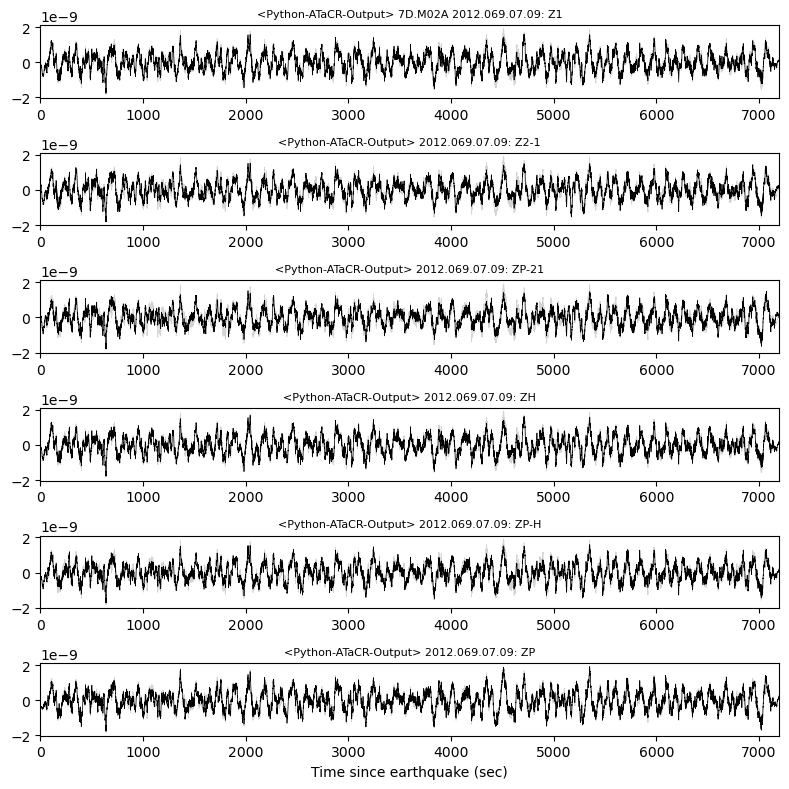

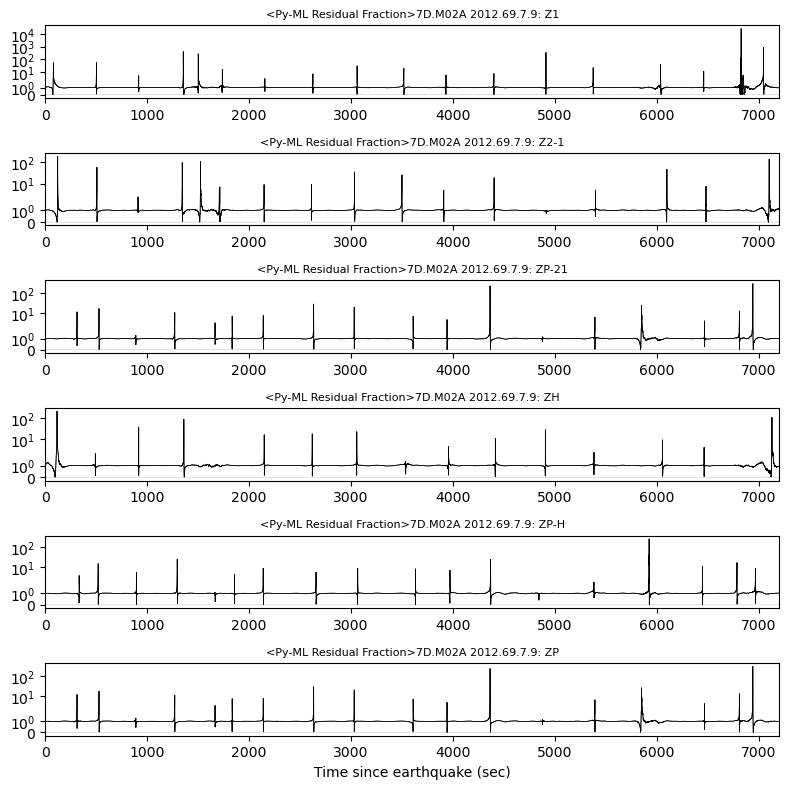

---------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------


'/Users/charlesh/Documents/Codes/ATaCR/ATaCR_Comp/ATaCR_Python/EVENTS/7D.M07A/CORRECTED/7D.M07A.2012.069.07.09.day.pkl'

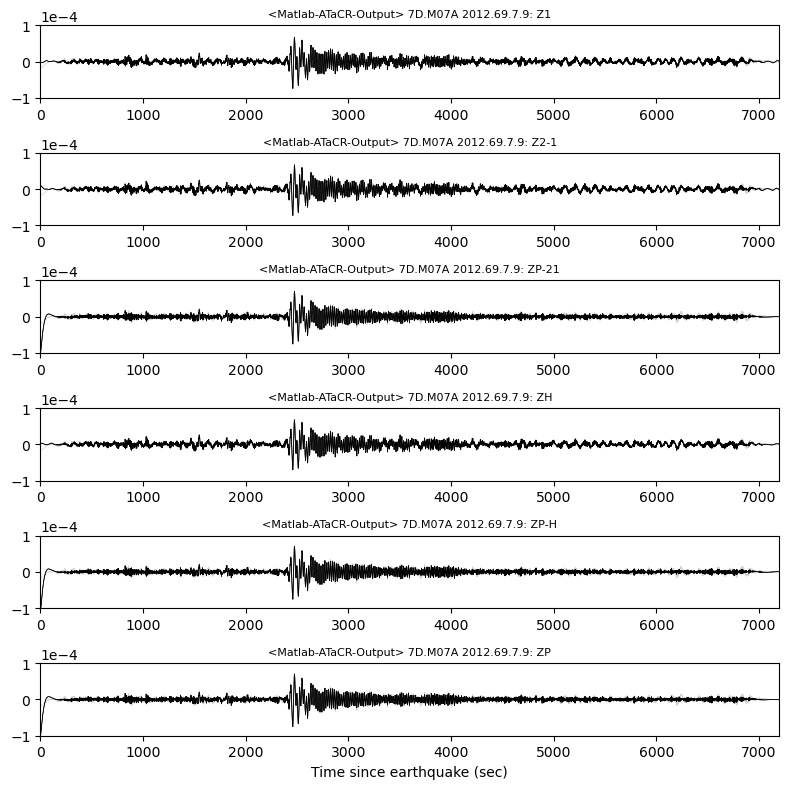

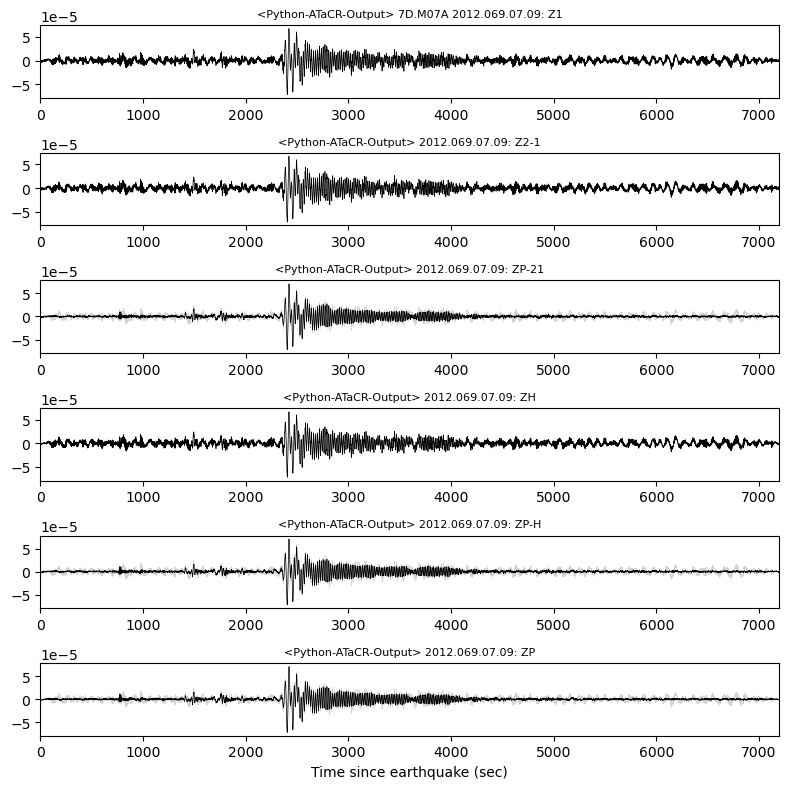

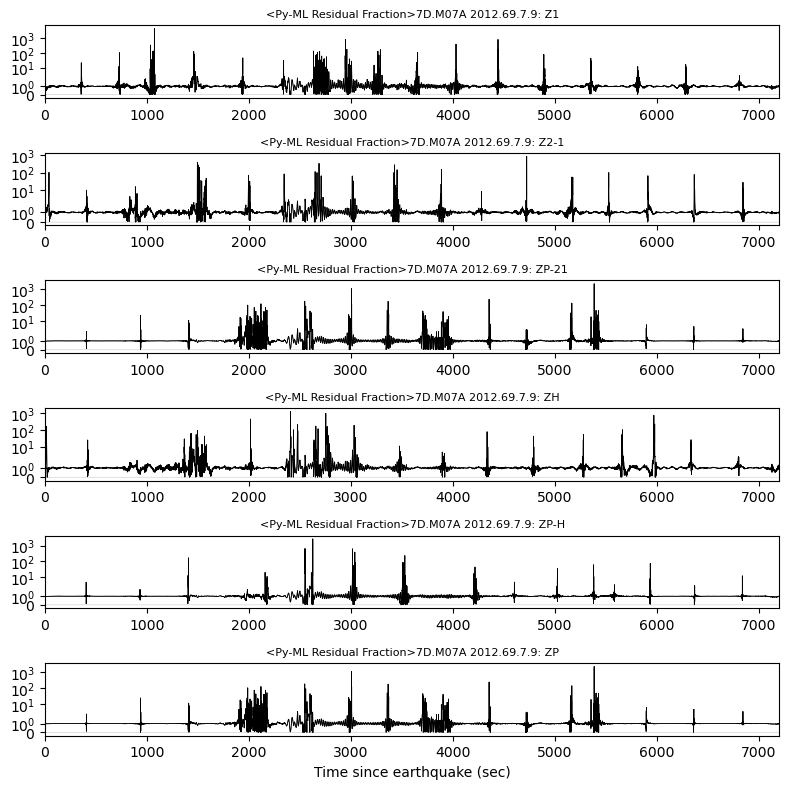

---------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------


'/Users/charlesh/Documents/Codes/ATaCR/ATaCR_Comp/ATaCR_Python/EVENTS/7D.M08A/CORRECTED/7D.M08A.2012.069.07.09.day.pkl'

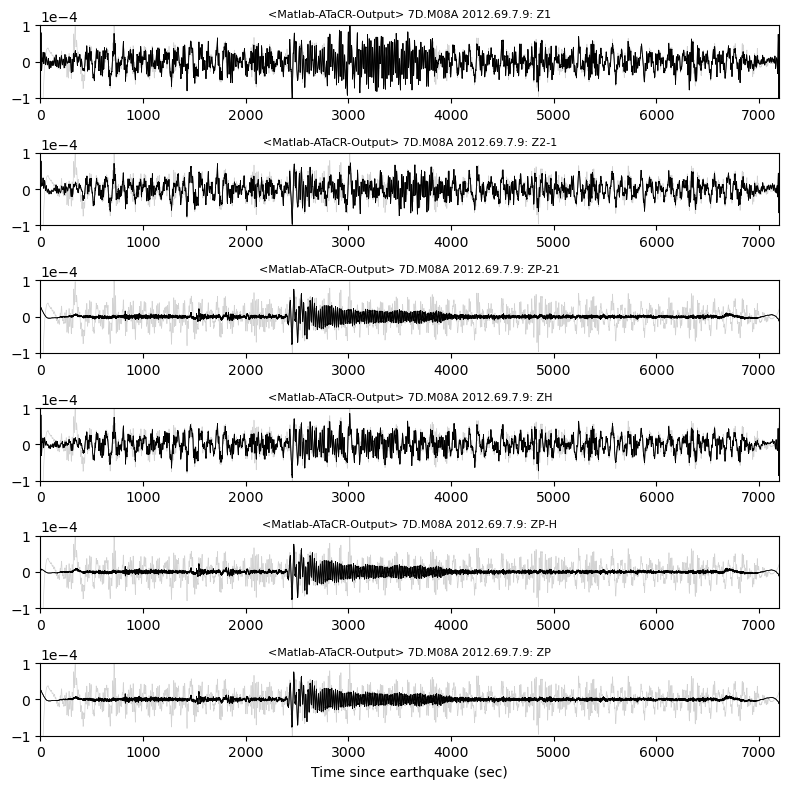

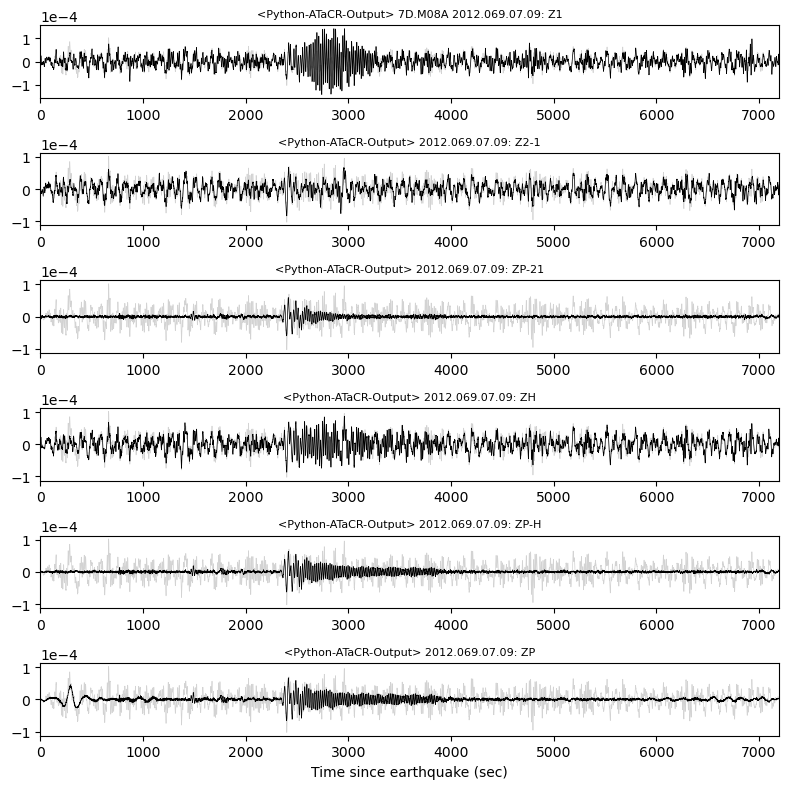

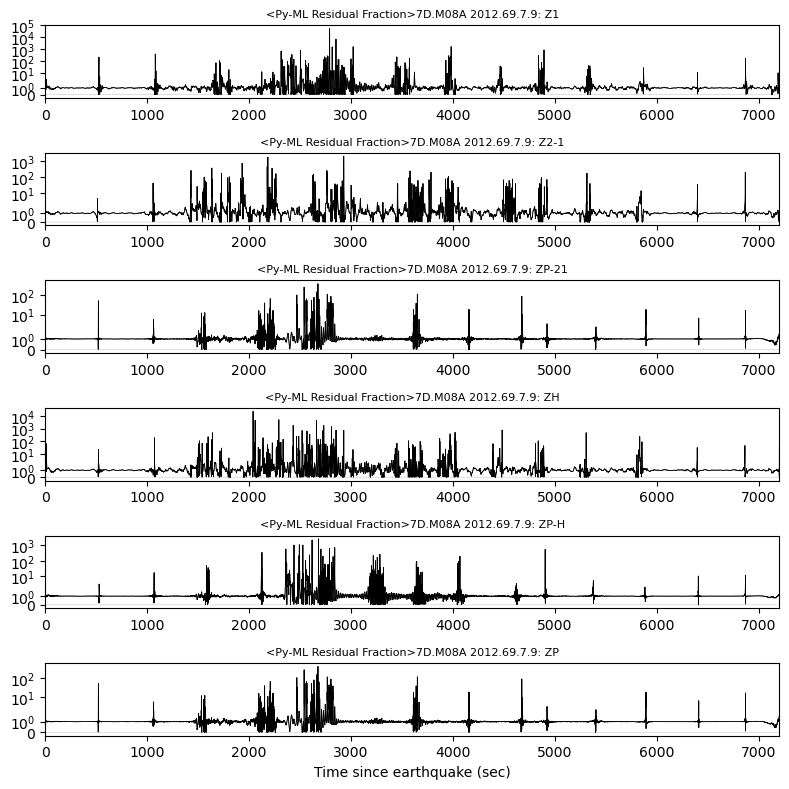

---------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------


In [4]:
for stai in stalist:
    # Matlab ATaCR output plot
    prefix = '<Matlab-ATaCR-Output> '
    ml_preprocevent_folder = 'ML_PreProcEventData'
    PreProcEvent,CorrectedEvent,ML_TFs = GetML_EventData_and_TransferFunctions(event_time,network,stai,ml_preprocevent_folder = ml_preprocevent_folder)
    if stai=='M02A':
        ylon = False
        yhard = [-0.2*np.mean(np.array(PreProcEvent['data'].to_list())),0.2*np.mean(PreProcEvent['data'].to_list())]
    else:
        ylon = True
        yhard = None
    TF_list = {i : j for i, j in zip(CorrectedEvent.label.to_list(), np.ones(len(CorrectedEvent.label.to_list()),dtype=bool))}
    ML_fig_event_corrected(PreProcEvent,CorrectedEvent,evstream=None, TF_list=TF_list, fmin=1./150., fmax=2.,prefix=prefix,ylon = ylon,yhard = yhard)

    # Python ATaCR output plot
    path = ATaCR_Py_DataFolder['Py_CorrectedTraces'] + '/' + network + '.' + stai + '/CORRECTED/' + network + '.' + stai + '.' + eventtime_jdaystr + '.day'
    py_files = g.glob(path + '*.pkl')
    f = py_files[0]
    display(f)
    evstream = pkl.load(open(f,'rb'))
    TF_list = {i : j for i, j in zip(list(evstream.correct.keys()), np.ones(len(list(evstream.correct.keys())),dtype=bool))}
    prefix = '<Python-ATaCR-Output> '
    Py_fig_event_corrected(evstream, TF_list, prefix=prefix)
    # Residual plot
    TraceDelta(event_time,network,stai,respct=True,scale='symlog')
    plt.show()
    print('---------------------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------------------')

obstools.atacr.plotting.fig_event_corrected(evstream, TF_list, fmin=0.006666666666666667, fmax=2.0)

Function to plot the corrected vertical component seismograms.

Parameters
:
evstream (EventStream) – Container for the event stream data

Tf_list (list) – List of Dictionary elements of transfer functions used for plotting the corrected vertical component.

File Chosen: 7D_M01A_b2_spectraavg.mat
Days Used: 


[{'id': '201203010000'},
 {'id': '201203020000'},
 {'id': '201203030000'},
 {'id': '201203040000'},
 {'id': '201203050000'},
 {'id': '201203060000'},
 {'id': '201203070000'},
 {'id': '201203080000'},
 {'id': '201203090000'}]

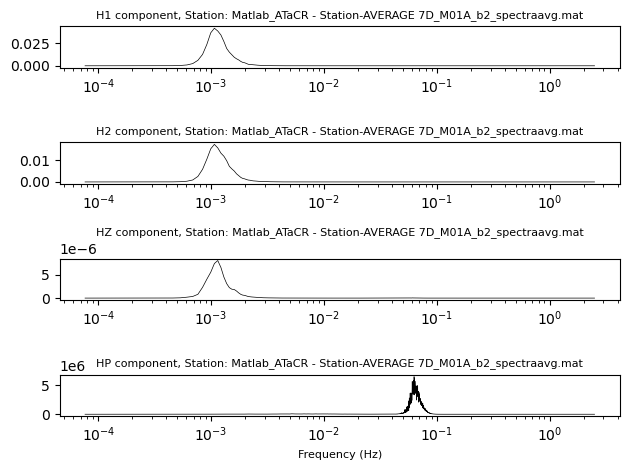

['/Users/charlesh/Documents/Codes/ATaCR/ATaCR_Comp/ATaCR_Python/AVG_STA/7D.M01A/2012.061-2012.070.avg_sta.pkl']

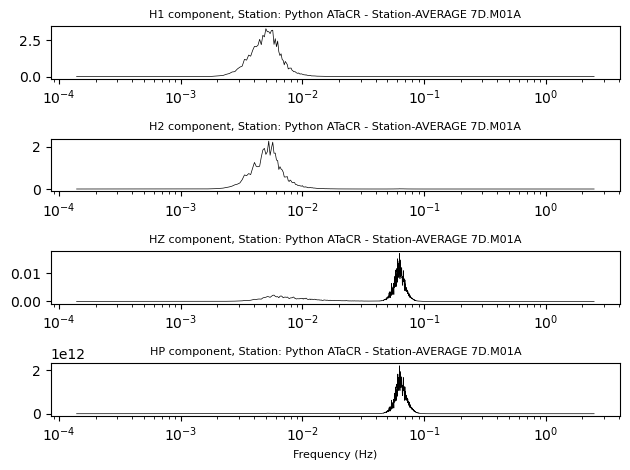

File Chosen: 7D_M02A_b2_spectraavg.mat
Days Used: 


[{'id': '201203010000'},
 {'id': '201203020000'},
 {'id': '201203030000'},
 {'id': '201203040000'},
 {'id': '201203060000'},
 {'id': '201203070000'},
 {'id': '201203080000'},
 {'id': '201203080000'},
 {'id': '201203090000'}]

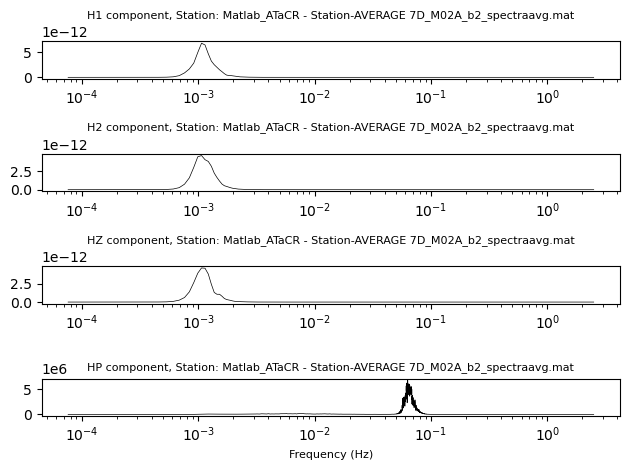

['/Users/charlesh/Documents/Codes/ATaCR/ATaCR_Comp/ATaCR_Python/AVG_STA/7D.M02A/2012.061-2012.070.avg_sta.pkl']

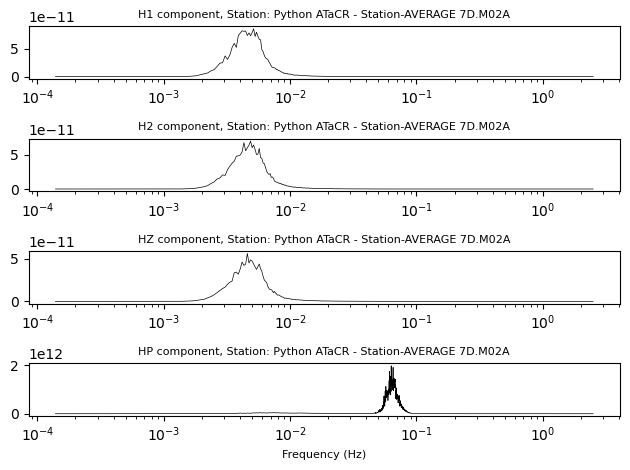

File Chosen: 7D_M07A_b2_spectraavg.mat
Days Used: 


[{'id': nan},
 {'id': '201203020000'},
 {'id': '201203030000'},
 {'id': '201203040000'},
 {'id': '201203050000'},
 {'id': '201203060000'},
 {'id': '201203070000'},
 {'id': '201203080000'},
 {'id': '201203090000'}]

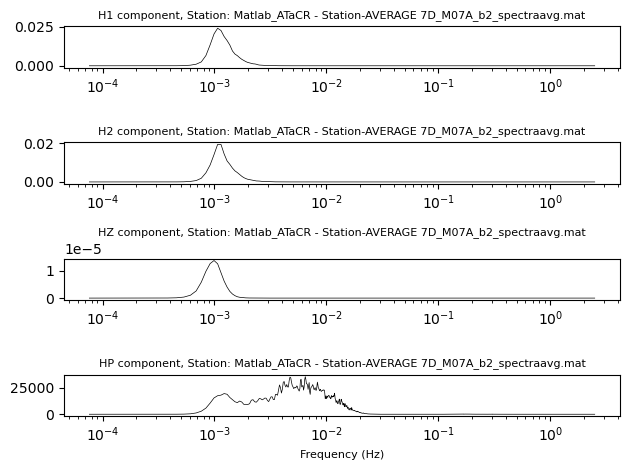

['/Users/charlesh/Documents/Codes/ATaCR/ATaCR_Comp/ATaCR_Python/AVG_STA/7D.M07A/2012.061-2012.070.avg_sta.pkl']

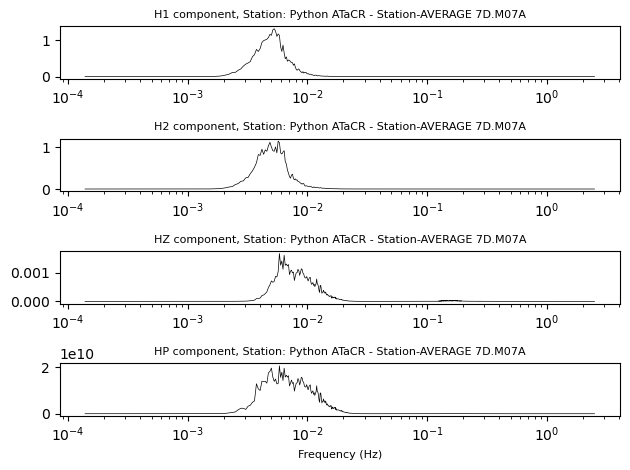

File Chosen: 7D_M08A_b2_spectraavg.mat
Days Used: 


[{'id': '201203010000'},
 {'id': '201203020000'},
 {'id': '201203030000'},
 {'id': '201203040000'},
 {'id': '201203050000'},
 {'id': '201203060000'},
 {'id': '201203070000'},
 {'id': '201203080000'},
 {'id': '201203090000'}]

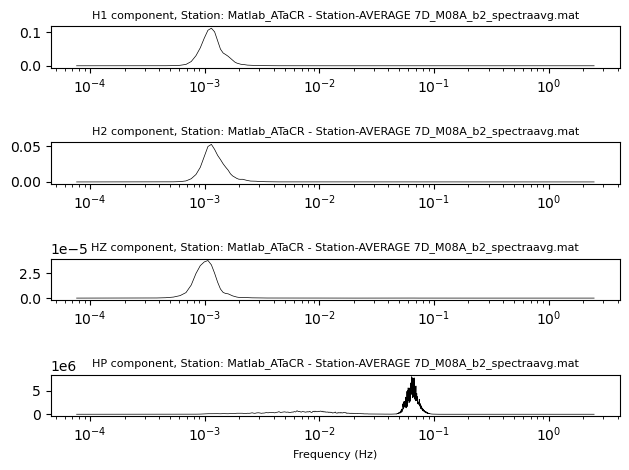

['/Users/charlesh/Documents/Codes/ATaCR/ATaCR_Comp/ATaCR_Python/AVG_STA/7D.M08A/2012.061-2012.070.avg_sta.pkl']

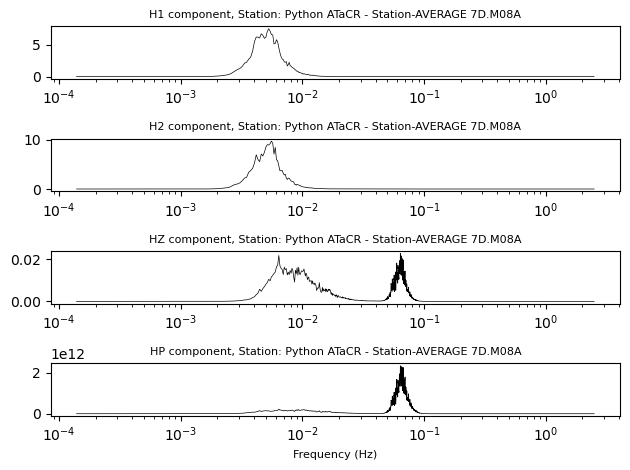

In [5]:
k = 'ML_StaSpecAvg'
# k = 'ML_b1b2_StaSpectra'
# folder = ATaCR_ML_DataFolder[k] + '/' + network + '/' + stai + '/b1'
# folder = ATaCR_ML_DataFolder[k] + '/' + network + '/' + stai + '/b2'
# ml_files = g.glob(folder + '/*.mat')
# print('Matlab-ATaCR Files: ' + str(len(ml_files)))
# display(ml_files)


for stai in stalist:
    folder = ATaCR_ML_DataFolder[k]
    if k=='ML_b1b2_StaSpectra':
        folder = ATaCR_ML_DataFolder[k] + '/' + network + '/' + stai + '/b1'
        folder = ATaCR_ML_DataFolder[k] + '/' + network + '/' + stai + '/b2'
    ml_files = g.glob(folder + '/*.mat')
    d = mat2df(ml_files)
    if k=='ML_StaSpecAvg':
        d = d[((d['network']==network)) & (d['station']==stai)].iloc[0]
        power = obstools.atacr.classes.Power(c11=np.atleast_2d(np.array(np.array(d.c11_mean.tolist()))).T,c22=np.atleast_2d(np.array(np.array(d.c22_mean.tolist()))).T,cZZ=np.atleast_2d(np.array(np.array(d.czz_mean.tolist()))).T,cPP=np.atleast_2d(np.array(np.array(d.cpp_mean.tolist()))).T)
    else:
        d = d[((d['network']==network)) & (d['station']==stai)]
        power = obstools.atacr.classes.Power(c11=np.atleast_2d(np.array(np.array(d.c11_stack.tolist()))).T,c22=np.atleast_2d(np.array(np.array(d.c22_stack.tolist()))).T,cZZ=np.atleast_2d(np.array(np.array(d.czz_stack.tolist()))).T,cPP=np.atleast_2d(np.array(np.array(d.cpp_stack.tolist()))).T)
    # display(d)
    ncomp = 4
    # Spectral Average of ML-ATaCR Data
    f = np.array(list(d.f))
    print('File Chosen: ' + d.File)

    if k=='ML_StaSpecAvg':
        print('Days Used: ' )
        display(list(d.daysused))

    key = 'Matlab_ATaCR - Station-AVERAGE ' + (d.File)
    gooddays = np.array([True],dtype=bool)
    fig_QC(f, power, gooddays, ncomp, key)
    plt.show()
# ------

    folder = ATaCR_Py_DataFolder['Py_StaSpecAvg']
    path = folder + '/' + network + '.' + stai + '/'
    py_files = g.glob(path + '*.pkl')
    # print('Python-ATaCR Files: ' + str(len(py_files)))
    display(py_files)
    f = py_files[0]
    # print('File Chosen: ' + f)
    # display('Dates used are encoded into the file name: ')
    # print(f.split('/')[-1])
    file = open(f, 'rb')
    pydata = pickle.load(file)
    fq = pydata.f
    gooddays = np.array([True],dtype=bool)
    ncomp = 4
    key = 'Python ATaCR - Station-AVERAGE ' + network + '.' + stai
    power = pydata.power
    c11=np.atleast_2d(power.c11).T
    c22=np.atleast_2d(power.c22).T
    cZZ=np.atleast_2d(power.cZZ).T
    cPP=np.atleast_2d(power.cPP).T
    fig_QC(fq, obstools.atacr.classes.Power(c11=c11, c22=c22, cZZ=cZZ, cPP=cPP), gooddays, ncomp, key)
    plt.show()